# Import dependencies

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from utils.data.load_root import load_root
from utils.data.build_graph import build_graphs
from utils.data.load_graphs import load_graphs
from utils.evaluation.evaluate_graphs import evaluate_data, evaluate_graphs
from utils.plotting.plot_events import plot_information, plot_event
from utils.data.graphdata import GraphDataset
from utils.models.interaction_network import InteractionNetwork
from utils.training.train_3 import train_model
from utils.evaluation.evaluate_model import evaluate_model


# Import Root data

In [2]:
%%time
load_rootdata = False

if load_rootdata:
    path = "~/Documents/Masterarbeit/Panda_Software/PandaRoot/dev/source/macro/data/evtcomplete"
    raw = load_root(path, showentries=True)
    raw.to_hdf('data/raw.h5', key='df', mode='w')  

else:
    raw = pd.read_hdf('data/raw.h5', 'df')  

CPU times: user 178 ms, sys: 104 ms, total: 282 ms
Wall time: 281 ms


Choose number of events to be analysed

In [3]:
nevents = raw.index.max()
nevents = 100
node_dim = 3
edge_dim = 3

# Investigate raw data

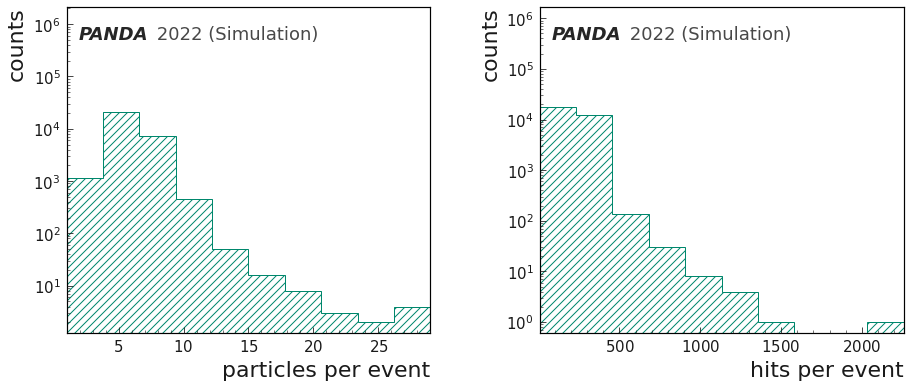

mean number of particles: 5.806633333333333, mean number of hits: 220.64846666666668


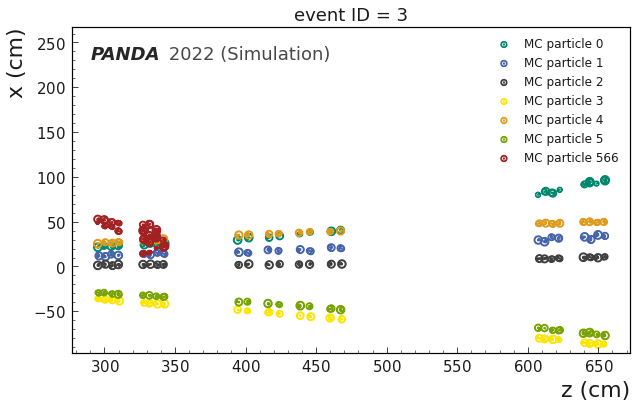

CPU times: user 2.97 s, sys: 1.35 s, total: 4.33 s
Wall time: 2.81 s


In [4]:
%%time

show=True
if show:
   
    plot_information(raw).plot_ntracks_nhits()
    evID=np.random.randint(nevents)
    evID = 3
    event = raw.loc[raw.index==evID]
    plot_event(event, scale=1.8).plot_eventdisplay()
    
#     data_eval = evaluate_data(raw, ncuts=50)
#     data_eval.plot_pzcut()
#     data_eval.curler_dist()

# Graph building for training

In [5]:
%%time
dir = 'data/graphs'
data = build_graphs(raw,end=nevents, shuffle=True, remove_duplicates=True)
create_g = False

if create_g:
    graphs = data.create_graph_list()
    targets = []


    for f in os.listdir(dir):
        os.remove(os.path.join(dir, f))

    for graph in graphs:
        evID = graph.pid.index.unique()[0]
        x, edge_attr, edge_index, y, pid = graph
        x = x[:,:node_dim]
        edge_attr = edge_attr[:edge_dim,:]
        targets.append(y)
        arr = np.asanyarray([x, edge_attr, edge_index, y, pid], dtype=object)
        np.save(f'{dir}/graph_{evID}.npy', arr)
    print(f'graphs saved to {dir}')

    targets = np.concatenate(targets)
    print(f'signal fraction true/all edges: {np.sum(targets)/len(targets)}')

graphs = load_graphs(dir, nevents, node_dim, edge_dim)

#show preprocessed data
data.events.sort_index()

CPU times: user 66.2 ms, sys: 9.12 ms, total: 75.3 ms
Wall time: 74.1 ms


,hit_id,x,z,iso,pz,chamber_id,skewed,particle_id,layer_id,Hit_id,layer,r,theta
event_id,,,,,,,,,,,,,
0,20289,27.522499,309.390015,0.381878,3.068213,1,0,1,7,155,3,310.611766,0.088724
0,7041,70.952499,653.489990,0.451314,7.614493,6,0,2,47,147,23,657.330529,0.108151
0,891,27.522499,437.489990,0.119575,2.421842,4,0,0,25,221,13,438.354856,0.062827
0,15646,20.452499,341.390015,0.382967,2.431979,2,0,0,15,211,7,342.002115,0.059838
0,10554,29.037500,327.769684,0.322732,3.068082,2,0,1,10,158,6,329.053403,0.088360
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,4609,-102.767502,653.489990,0.059770,9.606862,6,0,0,47,239,23,661.521222,-0.155982
100,886,8.332500,437.489990,0.393287,8.433346,4,0,3,25,121,13,437.569334,0.019044
100,13785,44.187500,327.769684,0.099623,3.149890,2,0,5,10,9,6,330.734789,0.134005


# Evaluate Graph building
for comparison with original raw data choose evaluate_graphs(data.raw.rename(columns={'layer_id':'layer'}), graphs).evaluate_graphs()

In [6]:
%%time
evaluate_gb = False

if evaluate_gb:
    slope = np.linspace(0.1,4,20)
    testdata = build_graphs(raw,end=100, shuffle=True, remove_duplicates=True)

    purities, efficiencies = np.zeros(len(slope)), np.zeros(len(slope))

    for i, s in enumerate(tqdm(slope)):
        testdata.slope = s
        testgraphs = testdata.create_graph_list(show_progress=False)
        purity, efficiency, _ = evaluate_graphs(testdata.events, testgraphs).evaluate_graphs(show_progress=False)
        purities[i] = np.mean(purity)
        efficiencies[i] = np.mean(efficiency)


    plot_information().plot_purity_efficiency(slope, 3, purities, efficiencies, 'slope cut', 'graph building', 'img/graphbuilding_purity_efficiency.pdf')

    plot_information(graphs=graphs).plot_graph_information()

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.3 µs


# Plot Graphs

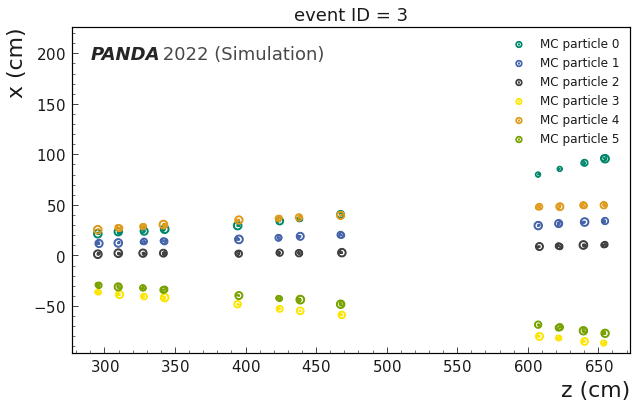

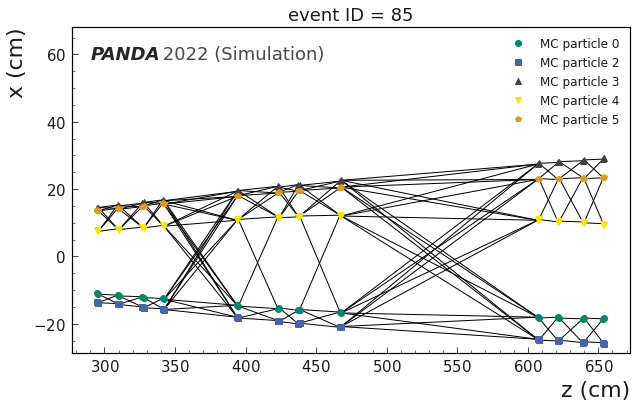

CPU times: user 1.38 s, sys: 259 ms, total: 1.64 s
Wall time: 1.34 s


In [7]:
%%time
evID = np.random.randint(nevents)
evID = 3

hits = data.events.loc[evID]
graph = graphs[evID]

plotevent = plot_event(hits, graph=graph , shift=.12, scale=1.6)
plotevent.plot_eventdisplay()
plotevent.plot_graphdisplay()




# Prepare Training

In [16]:
# torch.manual_seed(42)
device = 'cpu'
hidden_size = 6
name = f'IN_trained_events_{nevents}_neurons_{hidden_size}'
lr = 0.001
gamma = 0.7
epochs = 30
patience = 5
step_size = 4
batch_size = 1


parts = [0.8, 0.1, 0.1] #sizes of training, validation and testing samples
load_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 8}

In [17]:
parts = np.cumsum((nevents*np.array(parts)).astype(int))
partition = {'train': graphs[:parts[0]],  
             'test':  graphs[parts[0]:parts[1]],
             'val': graphs[parts[1]:parts[2]]}


train_set = GraphDataset(partition['train'])
train_loader = DataLoader(train_set, **load_params)
test_set = GraphDataset(partition['test'])
test_loader = DataLoader(test_set, **load_params)
val_set = GraphDataset(partition['val'])
val_loader = DataLoader(val_set, **load_params)

In [18]:
model = InteractionNetwork(hidden_size=hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

model.count_parameters()

InteractionNetwork(node_dim: 3, edge_dim: 3, hidden_size: 6)
+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| R1.layers.0.weight |     54     |
|  R1.layers.0.bias  |     6      |
| R1.layers.2.weight |     36     |
|  R1.layers.2.bias  |     6      |
| R1.layers.4.weight |     18     |
|  R1.layers.4.bias  |     3      |
| O.layers.0.weight  |     36     |
|  O.layers.0.bias   |     6      |
| O.layers.2.weight  |     36     |
|  O.layers.2.bias   |     6      |
| O.layers.4.weight  |     18     |
|  O.layers.4.bias   |     3      |
| R2.layers.0.weight |     54     |
|  R2.layers.0.bias  |     6      |
| R2.layers.2.weight |     36     |
|  R2.layers.2.bias  |     6      |
| R2.layers.4.weight |     6      |
|  R2.layers.4.bias  |     1      |
+--------------------+------------+
Total Trainable Params: 337


# Training

In [19]:
results = train_model(train_loader, val_loader, model, optimizer, scheduler, epochs=epochs, patience=patience, name=name)

  0%|                                                    | 0/30 [00:00<?, ?it/s]

Train Epoch: 1, epoch time: 0.67s
Mean Train Batch Loss: 0.6951


  3%|█▍                                          | 1/30 [00:00<00:26,  1.11it/s]


 Validation set: Average loss: 0.0691
, Accuracy: 0.5575

Validation loss decreased (inf --> 0.690484).  Saving model ...
Train Epoch: 2, epoch time: 0.68s
Mean Train Batch Loss: 0.6827


  7%|██▉                                         | 2/30 [00:01<00:25,  1.12it/s]


 Validation set: Average loss: 0.0682
, Accuracy: 0.6322

Validation loss decreased (0.690484 --> 0.668960).  Saving model ...
Train Epoch: 3, epoch time: 0.67s
Mean Train Batch Loss: 0.6328


 10%|████▍                                       | 3/30 [00:02<00:24,  1.10it/s]


 Validation set: Average loss: 0.0623
, Accuracy: 0.6478

Validation loss decreased (0.668960 --> 0.593026).  Saving model ...
Train Epoch: 4, epoch time: 0.66s
Mean Train Batch Loss: 0.5540


 13%|█████▊                                      | 4/30 [00:03<00:23,  1.12it/s]


 Validation set: Average loss: 0.0450
, Accuracy: 0.7532

Validation loss decreased (0.593026 --> 0.515413).  Saving model ...
Train Epoch: 5, epoch time: 0.65s
Mean Train Batch Loss: 0.4924


 17%|███████▎                                    | 5/30 [00:04<00:22,  1.13it/s]


 Validation set: Average loss: 0.0401
, Accuracy: 0.8267

Validation loss decreased (0.515413 --> 0.465543).  Saving model ...
Train Epoch: 6, epoch time: 0.65s
Mean Train Batch Loss: 0.4514


 20%|████████▊                                   | 6/30 [00:05<00:21,  1.13it/s]


 Validation set: Average loss: 0.0390
, Accuracy: 0.8362

Validation loss decreased (0.465543 --> 0.427497).  Saving model ...
Train Epoch: 7, epoch time: 0.68s
Mean Train Batch Loss: 0.4245


 23%|██████████▎                                 | 7/30 [00:06<00:20,  1.12it/s]


 Validation set: Average loss: 0.0435
, Accuracy: 0.8691

Validation loss decreased (0.427497 --> 0.403982).  Saving model ...
Train Epoch: 8, epoch time: 0.67s
Mean Train Batch Loss: 0.4052


 27%|███████████▋                                | 8/30 [00:07<00:19,  1.13it/s]


 Validation set: Average loss: 0.0260
, Accuracy: 0.8734

Validation loss decreased (0.403982 --> 0.387701).  Saving model ...
Train Epoch: 9, epoch time: 0.67s
Mean Train Batch Loss: 0.3891


 30%|█████████████▏                              | 9/30 [00:08<00:18,  1.13it/s]


 Validation set: Average loss: 0.0348
, Accuracy: 0.8838

Validation loss decreased (0.387701 --> 0.375646).  Saving model ...
Train Epoch: 10, epoch time: 0.67s
Mean Train Batch Loss: 0.3809


 33%|██████████████▎                            | 10/30 [00:08<00:17,  1.13it/s]


 Validation set: Average loss: 0.0307
, Accuracy: 0.9002

Validation loss decreased (0.375646 --> 0.371648).  Saving model ...
Train Epoch: 11, epoch time: 0.66s
Mean Train Batch Loss: 0.3718


 37%|███████████████▊                           | 11/30 [00:09<00:16,  1.13it/s]


 Validation set: Average loss: 0.0375
, Accuracy: 0.8993

Validation loss decreased (0.371648 --> 0.360671).  Saving model ...
Train Epoch: 12, epoch time: 0.69s
Mean Train Batch Loss: 0.3649


 40%|█████████████████▏                         | 12/30 [00:10<00:16,  1.11it/s]


 Validation set: Average loss: 0.0381
, Accuracy: 0.8989

Validation loss decreased (0.360671 --> 0.352480).  Saving model ...
Train Epoch: 13, epoch time: 0.65s
Mean Train Batch Loss: 0.3567


 43%|██████████████████▋                        | 13/30 [00:11<00:15,  1.11it/s]


 Validation set: Average loss: 0.0323
, Accuracy: 0.9032

Validation loss decreased (0.352480 --> 0.348746).  Saving model ...
Train Epoch: 14, epoch time: 0.70s
Mean Train Batch Loss: 0.3514


 47%|████████████████████                       | 14/30 [00:12<00:14,  1.10it/s]


 Validation set: Average loss: 0.0554
, Accuracy: 0.9054

Validation loss decreased (0.348746 --> 0.345388).  Saving model ...
Train Epoch: 15, epoch time: 0.67s
Mean Train Batch Loss: 0.3461


 50%|█████████████████████▌                     | 15/30 [00:13<00:13,  1.11it/s]


 Validation set: Average loss: 0.0363
, Accuracy: 0.9062

Validation loss decreased (0.345388 --> 0.342253).  Saving model ...
Train Epoch: 16, epoch time: 0.63s
Mean Train Batch Loss: 0.3427


 53%|██████████████████████▉                    | 16/30 [00:14<00:12,  1.12it/s]


 Validation set: Average loss: 0.0420
, Accuracy: 0.9118

Validation loss decreased (0.342253 --> 0.336891).  Saving model ...
Train Epoch: 17, epoch time: 0.70s
Mean Train Batch Loss: 0.3390


 57%|████████████████████████▎                  | 17/30 [00:15<00:11,  1.10it/s]


 Validation set: Average loss: 0.0359
, Accuracy: 0.9088

Validation loss decreased (0.336891 --> 0.333065).  Saving model ...
Train Epoch: 18, epoch time: 0.91s
Mean Train Batch Loss: 0.3359


 60%|█████████████████████████▊                 | 18/30 [00:16<00:11,  1.02it/s]


 Validation set: Average loss: 0.0230
, Accuracy: 0.9123

Validation loss decreased (0.333065 --> 0.330332).  Saving model ...
Train Epoch: 19, epoch time: 0.68s
Mean Train Batch Loss: 0.3332


 63%|███████████████████████████▏               | 19/30 [00:17<00:10,  1.04it/s]


 Validation set: Average loss: 0.0290
, Accuracy: 0.9123

Validation loss decreased (0.330332 --> 0.327389).  Saving model ...
Train Epoch: 20, epoch time: 0.61s
Mean Train Batch Loss: 0.3306


 67%|████████████████████████████▋              | 20/30 [00:18<00:09,  1.08it/s]


 Validation set: Average loss: 0.0410
, Accuracy: 0.9140

Validation loss decreased (0.327389 --> 0.325175).  Saving model ...
Train Epoch: 21, epoch time: 0.65s
Mean Train Batch Loss: 0.3275


 70%|██████████████████████████████             | 21/30 [00:19<00:08,  1.10it/s]


 Validation set: Average loss: 0.0351
, Accuracy: 0.9127

Validation loss decreased (0.325175 --> 0.322686).  Saving model ...
Train Epoch: 22, epoch time: 0.66s
Mean Train Batch Loss: 0.3262


 73%|███████████████████████████████▌           | 22/30 [00:19<00:07,  1.11it/s]


 Validation set: Average loss: 0.0194
, Accuracy: 0.9162

Validation loss decreased (0.322686 --> 0.321660).  Saving model ...
Train Epoch: 23, epoch time: 0.71s
Mean Train Batch Loss: 0.3248


 77%|████████████████████████████████▉          | 23/30 [00:20<00:06,  1.09it/s]


 Validation set: Average loss: 0.0283
, Accuracy: 0.9179

Validation loss decreased (0.321660 --> 0.321102).  Saving model ...
Train Epoch: 24, epoch time: 0.69s
Mean Train Batch Loss: 0.3228


 80%|██████████████████████████████████▍        | 24/30 [00:21<00:05,  1.09it/s]


 Validation set: Average loss: 0.0210
, Accuracy: 0.9144

Validation loss decreased (0.321102 --> 0.318517).  Saving model ...
Train Epoch: 25, epoch time: 0.67s
Mean Train Batch Loss: 0.3216


 83%|███████████████████████████████████▊       | 25/30 [00:22<00:04,  1.08it/s]


 Validation set: Average loss: 0.0330
, Accuracy: 0.9157

Validation loss decreased (0.318517 --> 0.316785).  Saving model ...
Train Epoch: 26, epoch time: 0.68s
Mean Train Batch Loss: 0.3200


 87%|█████████████████████████████████████▎     | 26/30 [00:23<00:03,  1.08it/s]


 Validation set: Average loss: 0.0190
, Accuracy: 0.9175

Validation loss decreased (0.316785 --> 0.316598).  Saving model ...
Train Epoch: 27, epoch time: 0.68s
Mean Train Batch Loss: 0.3187


 90%|██████████████████████████████████████▋    | 27/30 [00:24<00:02,  1.09it/s]


 Validation set: Average loss: 0.0205
, Accuracy: 0.9157

Validation loss decreased (0.316598 --> 0.314893).  Saving model ...
Train Epoch: 28, epoch time: 0.67s
Mean Train Batch Loss: 0.3188


 93%|████████████████████████████████████████▏  | 28/30 [00:25<00:01,  1.10it/s]


 Validation set: Average loss: 0.0222
, Accuracy: 0.9175

Validation loss decreased (0.314893 --> 0.314287).  Saving model ...
Train Epoch: 29, epoch time: 0.72s
Mean Train Batch Loss: 0.3172


 97%|█████████████████████████████████████████▌ | 29/30 [00:26<00:00,  1.08it/s]


 Validation set: Average loss: 0.0335
, Accuracy: 0.9188

Validation loss decreased (0.314287 --> 0.314181).  Saving model ...
Train Epoch: 30, epoch time: 0.66s
Mean Train Batch Loss: 0.3168


100%|███████████████████████████████████████████| 30/30 [00:27<00:00,  1.10it/s]


 Validation set: Average loss: 0.0219
, Accuracy: 0.9179

Validation loss decreased (0.314181 --> 0.312600).  Saving model ...


In [20]:
model, losses, accs, test_losses, test_accs = results.trained

# Evaluate Training

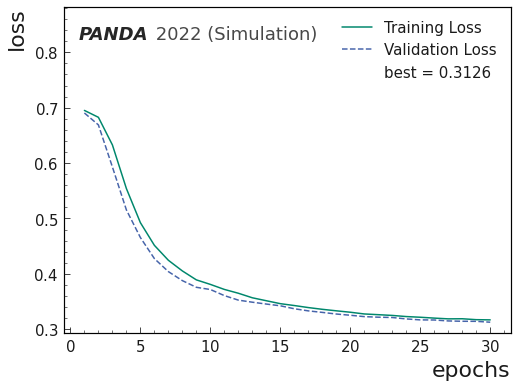

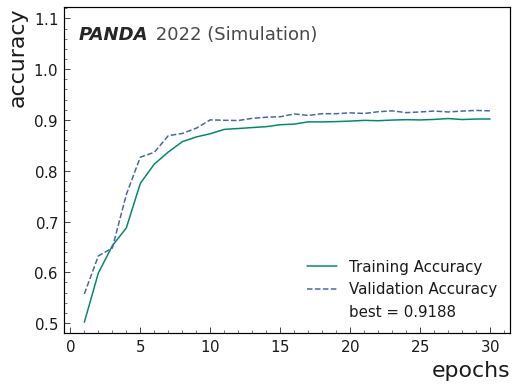

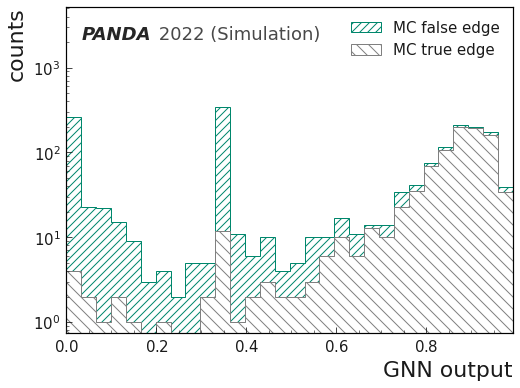

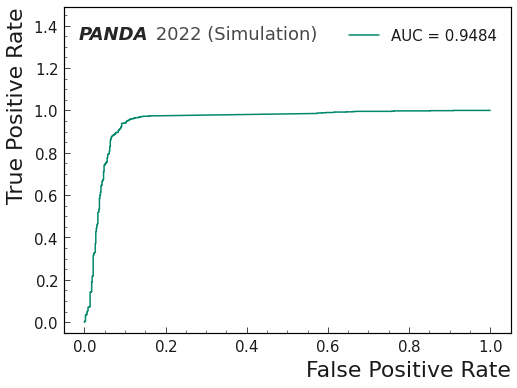

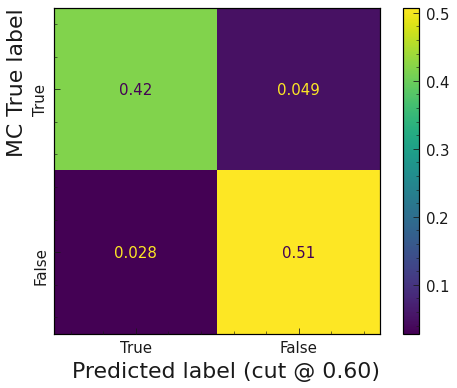

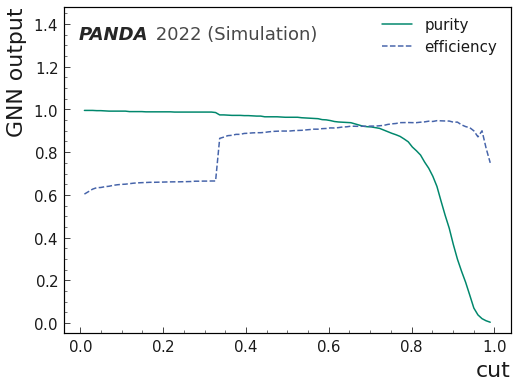

In [21]:
threshold = 0.6
evaluation = evaluate_model(model, test_loader, losses, test_losses, accs, test_accs, threshold, ncuts=100)
evaluation.plot_loss()
evaluation.plot_acc()
evaluation.plot_metrics()

# Show Results

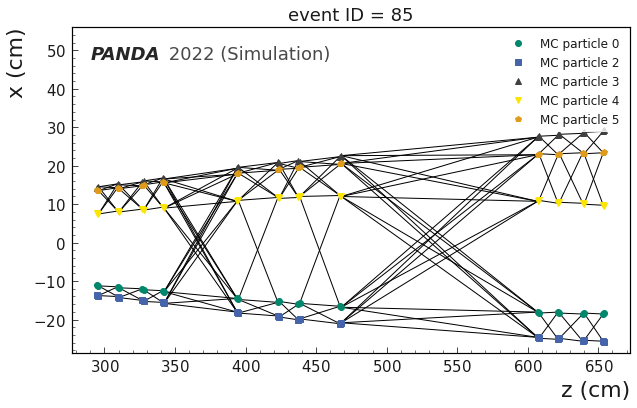

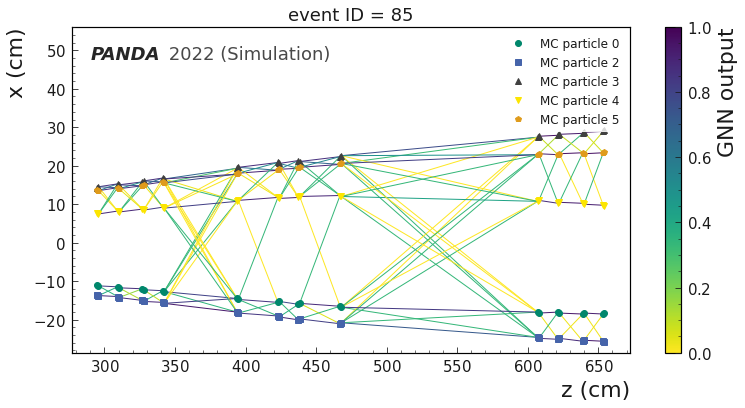

In [22]:
plot_event(hits, graph).plot_graphdisplay()
plot_event(hits, graph).plot_traineddisplay(model)